## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as  plt
from IPython.display import clear_output
import torchvision.utils as vutils
import numpy as np

## Utils

In [2]:

def show_two_images(tensor1, tensor2, nrow=1, titles=("Image1", "Image2")):
    """
    Show two batches of images side by side.
    tensor1, tensor2: [B,C,H,W] PyTorch tensors
    """
    def denormalize(tensor):
        return (tensor * 0.5) + 0.5  # from [-1,1] to [0,1]

    # make grids from each tensor
    grid1 = vutils.make_grid(denormalize(tensor1).cpu(), nrow=nrow)
    grid2 = vutils.make_grid(denormalize(tensor2).cpu(), nrow=nrow)

    npimg1 = grid1.permute(1, 2, 0).detach().numpy()
    npimg2 = grid2.permute(1, 2, 0).detach().numpy()

    # plot side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(npimg1)
    plt.axis("off")
    if titles and len(titles) > 0:
        plt.title(titles[0])

    plt.subplot(1, 2, 2)
    plt.imshow(npimg2)
    plt.axis("off")
    if titles and len(titles) > 1:
        plt.title(titles[1])

    plt.tight_layout()
    plt.show()

## Generator


In [3]:
# --- Basic building blocks ---
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=9):
        super().__init__()
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## Discriminator

In [4]:
# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

## Dataset Loader

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_X, root_Y, transform=None):
        self.files_X = [os.path.join(root_X, f) for f in os.listdir(root_X) if f.endswith(('jpg','png','jpeg'))]
        self.files_Y = [os.path.join(root_Y, f) for f in os.listdir(root_Y) if f.endswith(('jpg','png','jpeg'))]
        self.transform = transform

    def __len__(self):
        # number of iterations = max of both sets
        return max(len(self.files_X), len(self.files_Y))

    def __getitem__(self, index):
        # domain X image
        img_X_path = self.files_X[index % len(self.files_X)]
        img_X = Image.open(img_X_path).convert('RGB')

        # random domain Y image (unaligned)
        img_Y_path = random.choice(self.files_Y)
        img_Y = Image.open(img_Y_path).convert('RGB')

        if self.transform:
            img_X = self.transform(img_X)
            img_Y = self.transform(img_Y)

        return img_X, img_Y


In [6]:
transform = transforms.Compose([
    transforms.Resize((256,256)),         # resize all images
    transforms.ToTensor(),                # [0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # [-1,1]
])

In [7]:
dataset_folder='landscape_dataset'

dataset = ImageDataset(root_X=f'{dataset_folder}/trainA', root_Y=f'{dataset_folder}/trainB', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


## Loss Functions

In [8]:
# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()


## Params

In [9]:
epochs = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## Training

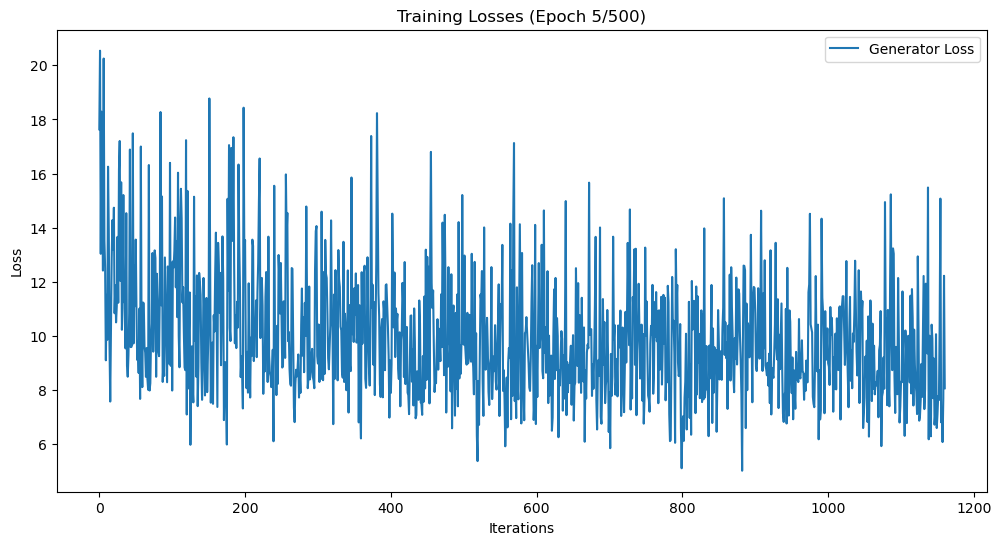

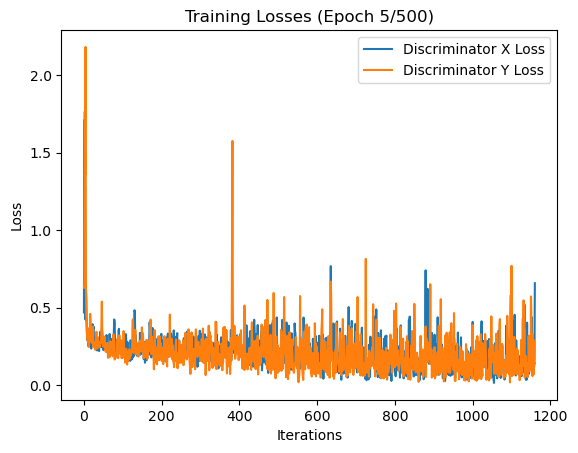

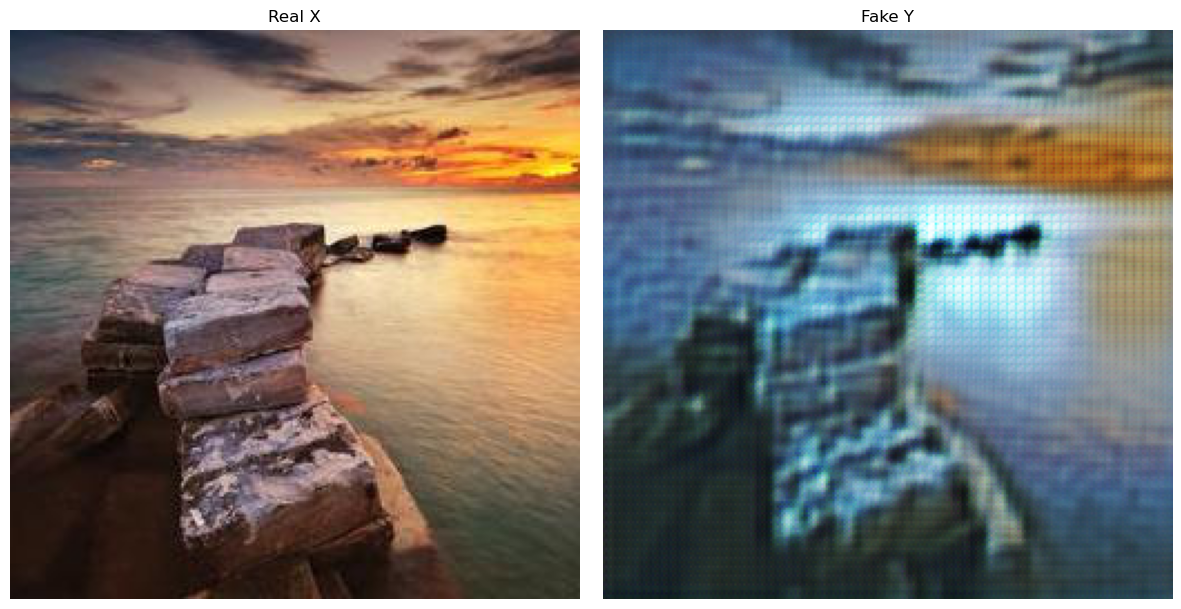

In [ ]:
# Initialize models
G_XtoY = Generator().to(device=device)
G_YtoX = Generator().to(device=device)
Disc_X = Discriminator().to(device=device)
Disc_Y = Discriminator().to(device=device)

# Optimizers
optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_X = optim.Adam(Disc_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(Disc_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Store losses for visualization
losses_G, losses_D_X, losses_D_Y = [], [], []
losses_cycle, losses_identity = [], []



plt.ion()
fig, ax = plt.subplots()
line1, = ax.plot([], [], label="Generator Loss")
line2, = ax.plot([], [], label="Discriminator X Loss")
line3, = ax.plot([], [], label="Discriminator Y Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
iteration=0

# Training loop skeleton
for epoch in range(epochs):
    for real_X, real_Y in dataloader:  # load mini-batches
        real_X, real_Y = real_X.to(device), real_Y.to(device)

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        fake_Y = G_XtoY(real_X)
        loss_GAN_XtoY = criterion_GAN(Disc_Y(fake_Y), torch.ones_like(Disc_Y(fake_Y)))

        fake_X = G_YtoX(real_Y)
        loss_GAN_YtoX = criterion_GAN(Disc_X(fake_X), torch.ones_like(Disc_X(fake_X)))

        # Cycle loss
        recov_X = G_YtoX(fake_Y)
        recov_Y = G_XtoY(fake_X)
        loss_cycle = criterion_cycle(recov_X, real_X) + criterion_cycle(recov_Y, real_Y)

        # Identity loss
        loss_id_X = criterion_identity(G_YtoX(real_X), real_X)
        loss_id_Y = criterion_identity(G_XtoY(real_Y), real_Y)

        # Total generator loss
        loss_G = loss_GAN_XtoY + loss_GAN_YtoX + 10.0 * loss_cycle + 5.0 * (loss_id_X + loss_id_Y)
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator X
        # -----------------------
        optimizer_D_X.zero_grad()

        loss_real = criterion_GAN(Disc_X(real_X), torch.ones_like(Disc_X(real_X)))
        loss_fake = criterion_GAN(Disc_X(fake_X.detach()), torch.zeros_like(Disc_X(fake_X)))
        loss_D_X = (loss_real + loss_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # -----------------------
        #  Train Discriminator Y
        # -----------------------
        optimizer_D_Y.zero_grad()

        loss_real = criterion_GAN(Disc_Y(real_Y), torch.ones_like(Disc_Y(real_Y)))
        loss_fake = criterion_GAN(Disc_Y(fake_Y.detach()), torch.zeros_like(Disc_Y(fake_Y)))
        loss_D_Y = (loss_real + loss_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
        ## Store losses
        losses_G.append(loss_G.item())
        losses_D_X.append(loss_D_X.item())
        losses_D_Y.append(loss_D_Y.item())
        losses_cycle.append(loss_cycle.item())
        losses_identity.append((loss_id_X + loss_id_Y).item())
        
        if iteration % 20 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12,6))
            
            plt.plot(losses_G, label="Generator Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.title(f"Training Losses (Epoch {epoch+1}/{epochs})")
            plt.show()
            
            plt.plot(losses_D_X, label="Discriminator X Loss")
            plt.plot(losses_D_Y, label="Discriminator Y Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.title(f"Training Losses (Epoch {epoch+1}/{epochs})")
            plt.show()
            
            show_two_images(real_X, fake_Y, nrow=1, titles=("Real X", "Fake Y"))
        iteration += 1

        
    # -----------------------
    # Save models every few epochs
    # -----------------------
    if (epoch + 1) % 10 == 0:
        save_dir = f"models/{dataset_folder}/epoch_{epoch}"

        # create directories if they don’t exist
        os.makedirs(save_dir, exist_ok=True)

        # now save your weights
        torch.save(G_XtoY.state_dict(), os.path.join(save_dir, "G_XtoY.pth"))
        torch.save(G_YtoX.state_dict(), os.path.join(save_dir, "G_YtoX.pth"))
        torch.save(Disc_X.state_dict(), os.path.join(save_dir, "Disc_X.pth"))
        torch.save(Disc_Y.state_dict(), os.path.join(save_dir, "Disc_Y.pth"))
        print(f"Saved models at epoch {epoch+1}")
